<a href="https://colab.research.google.com/github/amirkasaei/Compositional-Noise-Optimization/blob/main/Compositional_Metric_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup & utils

In [ ]:
from abc import ABC, abstractmethod

import torch


class BaseRewardLoss(ABC):
    """
    Base class for reward functions implementing a differentiable reward function for optimization.
    """

    def __init__(self, name: str, weighting: float):
        self.name = name
        self.weighting = weighting

    @staticmethod
    def freeze_parameters(params: torch.nn.ParameterList):
        for param in params:
            param.requires_grad = False

    @abstractmethod
    def get_image_features(self, image: torch.Tensor) -> torch.Tensor:
        pass

    @abstractmethod
    def get_text_features(self, prompt: str) -> torch.Tensor:
        pass

    @abstractmethod
    def compute(
        self, image_features: torch.Tensor, text_features: torch.Tensor
    ) -> torch.Tensor:
        pass

    def process_features(self, features: torch.Tensor) -> torch.Tensor:
        features_normed = features / features.norm(dim=-1, keepdim=True)
        return features_normed

    def __call__(self, image: torch.Tensor, prompt: str) -> torch.Tensor:
        image_features = self.get_image_features(image)
        text_features = self.get_text_features(prompt)

        image_features_normed = self.process_features(image_features)
        text_features_normed = self.process_features(text_features)

        score, loss = self.compute(image_features_normed, text_features_normed)
        return score, loss


In [ ]:
!pip install gdown
!gdown "https://drive.google.com/uc?id=1BUT7xbfOCx4cKu9A5fAxHs5UGvTPfyrV"

Downloading...
From (original): https://drive.google.com/uc?id=1BUT7xbfOCx4cKu9A5fAxHs5UGvTPfyrV
From (redirected): https://drive.google.com/uc?id=1BUT7xbfOCx4cKu9A5fAxHs5UGvTPfyrV&confirm=t&uuid=91ae5a88-7c9a-456a-a055-8976fa3d41f4
To: /content/human_eval_images_T2I_Compbench.rar
100% 1.02G/1.02G [00:17<00:00, 58.7MB/s]


In [ ]:
import pandas as pd

! pip install rarfile
import rarfile
import os

# from google.colab import drive

# drive.mount('/content/drive')

# Add the dataset to your drive and mount your drive on colab
RAR_FILE_PATH = "/content/human_eval_images_T2I_Compbench.rar"
EXTRACTION_PATH = "human_eval_images_T2I_Compbench"

os.makedirs(EXTRACTION_PATH, exist_ok=True)

if not os.listdir(EXTRACTION_PATH):
    print("Extracting the RAR file as the directory is empty.")

    # Extract the .rar file
    with rarfile.RarFile(RAR_FILE_PATH) as rf:
        rf.extractall(EXTRACTION_PATH)
else:
    print("The directory already contains files. Skipping extraction.")


files = os.listdir(EXTRACTION_PATH)
print(files)

PATH = EXTRACTION_PATH + "/"
IMAGE_PATH = PATH + "images_all/"
JSON_PATH = PATH+"annotation_all.json"

The directory already contains files. Skipping extraction.
['cache', 'annotation_all.json', 'images_all']


In [ ]:
import pandas as pd

df = pd.read_json(JSON_PATH)
df.head()

,image_name,category,method,prompt,score
0,0_0_00.png,color,Stable Diffusion v1.4,a brown backpack and a blue cow,3.000000
1,0_0_01.png,color,Stable Diffusion v1.4,a brown backpack and a blue cow,2.333333
2,0_0_02.png,color,Stable Diffusion v1.4,a brown bear and a red book,3.000000
3,0_0_03.png,color,Stable Diffusion v1.4,a brown bear and a red book,3.000000
4,0_0_04.png,color,Stable Diffusion v1.4,a red bear and a brown book,3.000000


In [ ]:
for col in ["category", "method"]:
    unique_values = df[col].unique()  # Get unique values
    unique_counts = df[col].value_counts()  # Get the count of each unique value

    print(f"Column: {col}")
    print(f"Unique values: {unique_values}")
    print("Counts of unique values:")
    print(unique_counts)
    print("\n")

Column: category
Unique values: ['color' 'shape' 'texture' '2d-spatial relationship'
 'non-spatial relationship' 'complex' '3d-spatial relationship' 'numeracy']
Counts of unique values:
category
color                       300
shape                       300
texture                     300
2d-spatial relationship     300
non-spatial relationship    300
complex                     300
3d-spatial relationship     300
numeracy                    300
Name: count, dtype: int64


Column: method
Unique values: ['Stable Diffusion v1.4' 'Stable Diffusion v2' 'Structure Diffusion v2'
 'Composable Diffusion v2' 'Attend-and-Excite v2' 'GORS']
Counts of unique values:
method
Stable Diffusion v1.4      400
Stable Diffusion v2        400
Structure Diffusion v2     400
Composable Diffusion v2    400
Attend-and-Excite v2       400
GORS                       400
Name: count, dtype: int64




In [ ]:
from transformers import AutoProcessor

weighting= 1.0
cache_dir = PATH + "cache"
dtype = torch.float16
device = torch.device("cuda")
tokenizer = AutoProcessor.from_pretrained("laion/CLIP-ViT-H-14-laion2B-s32B-b79K", cache_dir=cache_dir)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
!nvidia-smi

Sat Oct 26 18:31:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from torchvision.transforms import Compose, Resize, CenterCrop, Normalize, ToTensor
from torchvision.transforms.functional import InterpolationMode

def clip_img_transform(size: int = 224):
    return Compose(
        [
            Resize(size, interpolation=InterpolationMode.BICUBIC),
            CenterCrop(size),
            ToTensor(),
            Normalize(
                (0.48145466, 0.4578275, 0.40821073),
                (0.26862954, 0.26130258, 0.27577711),
            ),
        ]
    )

In [ ]:
from PIL import Image

def score_loss_extractor(model, img_path, prompt):
    img = Image.open(img_path)
    preprocessed_img = clip_img_transform(224)(img)
    preprocessed_img = preprocessed_img.unsqueeze(0).to(device)
    return model(preprocessed_img, prompt)


In [ ]:
def get_range_score(df, column):
  return df_with_scores[column].min(), df_with_scores[column].max()

## PickScore

In [ ]:
import torch
from transformers import AutoModel

# TODO : ASK : calling method : score or loss

class PickScore(BaseRewardLoss):
    """PickScore reward loss function for optimization."""

    def __init__(
        self,
        weighting: float,
        dtype: torch.dtype,
        device: torch.device,
        cache_dir: str,
        tokenizer,
    ):
        self.tokenizer = tokenizer
        self.pickscore_model = AutoModel.from_pretrained(
            "yuvalkirstain/PickScore_v1", cache_dir=cache_dir
        ).eval()

        if memsave:
            import memsave_torch.nn

            self.pickscore_model = memsave_torch.nn.convert_to_memory_saving(
                self.pickscore_model
            )

        self.pickscore_model = self.pickscore_model.to(device, dtype=dtype)
        self.freeze_parameters(self.pickscore_model.parameters())
        super().__init__("PickScore", weighting)
        self.pickscore_model._set_gradient_checkpointing(True)

    def get_image_features(self, image) -> torch.Tensor:
        reward_img_features = self.pickscore_model.get_image_features(image)
        return reward_img_features

    def get_text_features(self, prompt: str) -> torch.Tensor:
        prompt_token = self.tokenizer(
            prompt, return_tensors="pt", padding=True, max_length=77, truncation=True
        ).to("cuda")
        reward_text_features = self.pickscore_model.get_text_features(**prompt_token)
        return reward_text_features

    def compute(
        self, image_features: torch.Tensor, text_features: torch.Tensor
    ) -> torch.Tensor:

        pickscore_score = (
                self.pickscore_model.logit_scale.exp()
                * (image_features @ text_features.T)
            ).mean()

        pickscore_loss = 30 - pickscore_score

        return pickscore_score, pickscore_loss



In [ ]:
pick_score = PickScore(
                weighting,
                dtype,
                device,
                cache_dir,
                tokenizer)

## CLIP

In [ ]:
import torch
from transformers import CLIPModel

class CLIPScore(BaseRewardLoss):
    """CLIP reward loss function for optimization."""

    def __init__(
        self,
        weigthing: float,
        dtype: torch.dtype,
        device: torch.device,
        cache_dir: str,
        tokenizer,
        memsave: bool = False,
    ):
        self.tokenizer = tokenizer
        self.clip_model = CLIPModel.from_pretrained(
            "laion/CLIP-ViT-H-14-laion2B-s32B-b79K",
            cache_dir=cache_dir,
        )
        # print(self.clip_model.logit_scale)

        if memsave:
            import memsave_torch.nn
            self.clip_model = memsave_torch.nn.convert_to_memory_saving(self.clip_model)

        self.clip_model = self.clip_model.to(device, dtype=dtype)
        self.clip_model.eval()
        self.freeze_parameters(self.clip_model.parameters())
        super().__init__("CLIP", weighting)
        self.clip_model.gradient_checkpointing_enable()

    def get_image_features(self, image: torch.Tensor) -> torch.Tensor:
        clip_img_features = self.clip_model.get_image_features(image)
        return clip_img_features

    def get_text_features(self, prompt: str) -> torch.Tensor:
        prompt_token = self.tokenizer(
            prompt, return_tensors="pt", padding=True, max_length=77, truncation=True
        ).to("cuda")
        clip_text_features = self.clip_model.get_text_features(**prompt_token)
        return clip_text_features

    def compute(
        self, image_features: torch.Tensor, text_features: torch.Tensor
    ) -> torch.Tensor:

        clip_score = (image_features @ text_features.T).mean() * self.clip_model.logit_scale.exp()
        clip_loss = 100 - clip_score

        return clip_score, clip_loss


In [ ]:
clip_score = CLIPScore(
                weighting,
                dtype,
                device,
                cache_dir,
                tokenizer)

## HPS

In [ ]:
!pip install hpsv2

import os
import requests
import shutil

# Function to download and move the missing file
def download_bpe_vocab_file():
    url = 'https://dl.fbaipublicfiles.com/mmf/clip/bpe_simple_vocab_16e6.txt.gz'
    destination_path = '/usr/local/lib/python3.10/dist-packages/hpsv2/src/open_clip/'
    filename = 'bpe_simple_vocab_16e6.txt.gz'

    # Check if the file already exists
    if not os.path.exists(os.path.join(destination_path, filename)):
        print(f"Downloading {filename}...")
        response = requests.get(url, stream=True)

        # Check if the request was successful
        if response.status_code == 200:
            # Save the file temporarily
            with open(filename, 'wb') as out_file:
                shutil.copyfileobj(response.raw, out_file)
            print(f"Downloaded {filename} successfully.")

            # Move the file to the correct path
            if not os.path.exists(destination_path):
                os.makedirs(destination_path)
            shutil.move(filename, os.path.join(destination_path, filename))
            print(f"Moved {filename} to {destination_path}.")
        else:
            print(f"Failed to download the file. Status code: {response.status_code}")
    else:
        print(f"{filename} already exists in {destination_path}.")

# Call the function to ensure the file is available before model creation
%%capture
download_bpe_vocab_file()

In [ ]:

from hpsv2.src.open_clip import create_model, get_tokenizer
import huggingface_hub


class HPS(BaseRewardLoss):
    """HPS reward loss function for optimization."""

    def __init__(
        self,
        weighting: float,
        dtype: torch.dtype,
        device: torch.device,
        cache_dir: str,
        memsave: bool = False,
    ):
        self.hps_model = create_model(
            "ViT-H-14",
            "laion2B-s32B-b79K",
            precision=dtype,
            device=device,
            cache_dir=cache_dir,
        )

        checkpoint_path = huggingface_hub.hf_hub_download(
            "xswu/HPSv2", "HPS_v2.1_compressed.pt", cache_dir=cache_dir
        )
        self.hps_model.load_state_dict(
            torch.load(checkpoint_path, map_location=device)["state_dict"]
        )

        self.hps_tokenizer = get_tokenizer("ViT-H-14")

        if memsave:
            import memsave_torch.nn
            self.hps_model = memsave_torch.nn.convert_to_memory_saving(self.hps_model)

        self.hps_model = self.hps_model.to(device, dtype=dtype)
        self.hps_model.eval()
        self.freeze_parameters(self.hps_model.parameters())
        super().__init__("HPS", weighting)
        self.hps_model.set_grad_checkpointing(True)

    def get_image_features(self, image: torch.Tensor) -> torch.Tensor:
        # TODO : ASK
        image = image.half()

        hps_image_features = self.hps_model.encode_image(image)
        return hps_image_features

    def get_text_features(self, prompt: str) -> torch.Tensor:
        hps_text = self.hps_tokenizer(prompt).to("cuda")
        hps_text_features = self.hps_model.encode_text(hps_text)
        return hps_text_features

    def compute(
        self, image_features: torch.Tensor, text_features: torch.Tensor
    ) -> torch.Tensor:
        logits_per_image = image_features @ text_features.T

        hps_score = torch.diagonal(logits_per_image)[0]
        hps_loss = 1 - hps_score
        return hps_score, hps_loss


In [ ]:
hps_score = HPS(
                weighting,
                dtype,
                device,
                cache_dir)

INFO:root:Loaded ViT-H-14 model config.
INFO:root:Loading pretrained ViT-H-14 weights (laion2B-s32B-b79K).


## ImageReward

In [ ]:
!git init
!git clone https://github.com/THUDM/ImageReward.git
!cd ImageReward
!pip install image-reward
!pip install git+https://github.com/openai/CLIP.git

In [ ]:
import ImageReward as RM

class ImageReward(BaseRewardLoss):
    """Image reward loss for optimization."""

    def __init__(
        self,
        weighting: float,
        dtype: torch.dtype,
        device: torch.device,
        cache_dir: str,
        memsave: bool = False,
    ):
        self.name = "ImageReward"
        self.weighting = weighting
        self.dtype = dtype
        self.imagereward_model = RM.load("ImageReward-v1.0", download_root=cache_dir)
        self.imagereward_model = self.imagereward_model.to(
            device=device, dtype=self.dtype
        )
        self.imagereward_model.eval()
        BaseRewardLoss.freeze_parameters(self.imagereward_model.parameters())

    def get_image_features(self, image: torch.Tensor) -> torch.Tensor:
        image_embeds = self.imagereward_model.blip.visual_encoder(image)
        return image_embeds

    def get_text_features(self, prompt: str) -> torch.Tensor:
        text_input = self.imagereward_model.blip.tokenizer(
            prompt,
            padding="max_length",
            truncation=True,
            max_length=35,
            return_tensors="pt",
        ).to(self.imagereward_model.device)

        return text_input

    def __call__(self, image: torch.Tensor, prompt: str) -> torch.Tensor:
        if next(self.imagereward_model.parameters()).dtype == torch.float16:
            image = image.half()

        text_input = self.get_text_features(prompt)
        image_embeds = self.get_image_features(image)

        score, loss = self.compute(image_embeds, text_input)
        return score, loss

    def compute(
        self, image_embeds: torch.Tensor, text_input: torch.Tensor
    ) -> torch.Tensor:

        image_atts = torch.ones(image_embeds.size()[:-1], dtype=torch.long).to(
            self.imagereward_model.device
        )

        text_output = self.imagereward_model.blip.text_encoder(
            text_input.input_ids,
            attention_mask=text_input.attention_mask,
            encoder_hidden_states=image_embeds,
            encoder_attention_mask=image_atts,
            return_dict=True,
        )

        txt_features = text_output.last_hidden_state[:, 0, :].to(
            self.imagereward_model.device, dtype=self.dtype
        )
        rewards = self.imagereward_model.mlp(txt_features)
        rewards = (rewards - self.imagereward_model.mean) / self.imagereward_model.std

        return rewards.mean(), (2 - rewards).mean()


In [ ]:
image_reward = ImageReward(
              weighting,
              dtype,
              device,
              cache_dir)

load checkpoint from human_eval_images_T2I_Compbench/cache/ImageReward.pt
checkpoint loaded


## Aesthetic

In [ ]:
!pip install pytorch_lightning
!mkdir ckpts
!gdown --id 1rzs--1TRsY_aaTUfCrJNMqJlV5xNKQMx -O "/content/ckpts/aesthetic-model.pth"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 53.0 MB/s eta 0:00:00
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1rzs--1TRsY_aaTUfCrJNMqJlV5xNKQMx
To: /content/ckpts/aesthetic-model.pth
100% 3.71M/3.71M [00:00<00:00, 250MB/s]


In [ ]:
import os

import clip
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F


class Aesthetic(BaseRewardLoss):
    """CLIP reward loss function for optimization."""

    def __init__(
        self,
        weigthing: float,
        dtype: torch.dtype,
        device: torch.device,
        cache_dir: str,
        memsave: bool = False,
    ):
        self.memsave = memsave
        self.clip_model, self.preprocess_fn = clip.load(
            "ViT-L/14", device=device, download_root=cache_dir
        )
        self.clip_model = self.clip_model.to(device, dtype=dtype)
        self.mlp = MLP(768).to(device, dtype=dtype)
        s = torch.load(
            f"{os.getcwd()}/ckpts/aesthetic-model.pth"
        )  # load the model you trained previously or the model available in this repo
        self.mlp.load_state_dict(s)
        self.clip_model.eval()

        if memsave:
            import memsave_torch.nn

            self.mlp = memsave_torch.nn.convert_to_memory_saving(self.mlp)
            self.clip_model = memsave_torch.nn.convert_to_memory_saving(
                self.clip_model
            ).to(device, dtype=dtype)

        self.freeze_parameters(self.clip_model.parameters())
        self.freeze_parameters(self.mlp.parameters())
        super().__init__("Aesthetic", weighting)

    def get_image_features(self, image: torch.Tensor) -> torch.Tensor:
        with torch.autocast("cuda"):
            clip_img_features = self.clip_model.encode_image(image)
            l2 = torch.norm(clip_img_features, p=2, dim=-1, keepdim=True)
            l2 = torch.where(
                l2 == 0,
                torch.tensor(
                    1.0, device=clip_img_features.device, dtype=clip_img_features.dtype
                ),
                l2,
            )
            clip_img_features = clip_img_features / l2
        return clip_img_features

    def get_text_features(self, prompt: str) -> torch.Tensor:
        return None

    def __call__(self, image: torch.Tensor, prompt: torch.Tensor) -> torch.Tensor:
        if self.memsave:
            image = image.to(torch.float32)

        image_features = self.get_image_features(image)
        image_features_normed = self.process_features(image_features.to(torch.float16))

        score, loss = self.compute(image_features_normed, prompt)
        return score, loss

    def compute(
        self, image_features: torch.Tensor, text_features: torch.Tensor
    ) -> torch.Tensor:
        aesthetic_score = self.mlp(image_features).mean()
        aesthetic_loss = 10.0 - aesthetic_score

        return aesthetic_score, aesthetic_loss


class MLP(pl.LightningModule):
    def __init__(self, input_size, xcol="emb", ycol="avg_rating"):
        super().__init__()
        self.input_size = input_size
        self.xcol = xcol
        self.ycol = ycol
        self.layers = nn.Sequential(
            nn.Linear(self.input_size, 1024),
            # nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 128),
            # nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            # nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 16),
            # nn.ReLU(),
            nn.Linear(16, 1),
        )

    def forward(self, x):
        return self.layers(x)

    def training_step(self, batch, batch_idx):
        x = batch[self.xcol]
        y = batch[self.ycol].reshape(-1, 1)
        x_hat = self.layers(x)
        loss = F.mse_loss(x_hat, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x = batch[self.xcol]
        y = batch[self.ycol].reshape(-1, 1)
        x_hat = self.layers(x)
        loss = F.mse_loss(x_hat, y)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [ ]:
weighting= 1.0
aesthetic = Aesthetic(
              weighting,
              dtype,
              device,
              cache_dir)

## Process

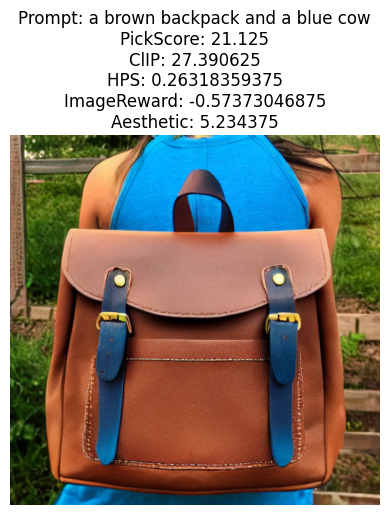

In [ ]:
import matplotlib.pyplot as plt

sample = df.iloc[0]

img_path =  IMAGE_PATH + sample["image_name"]
prompt = sample["prompt"]

pickscore_sl = score_loss_extractor(pick_score, img_path, prompt)
clip_sl = score_loss_extractor(clip_score, img_path, prompt)
hps_sl = score_loss_extractor(hps, img_path, prompt)
imagereward_sl = score_loss_extractor(image_reward, img_path, prompt)
aesthetic_sl = score_loss_extractor(aesthetic, img_path, prompt)

plt.imshow(Image.open(img_path))
plt.title(f"Prompt: {prompt}\nPickScore: {pickscore_sl[0]}\nClIP: {clip_sl[0]}\nHPS: {hps_sl[0]}\nImageReward: {imagereward_sl[0]}\nAesthetic: {aesthetic_sl[0]}")
plt.axis('off')
plt.show()



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
import os.path

json_with_scores = {}
file_path = '/content/drive/MyDrive/Results/scores.json'

if os.path.isfile(file_path):
  with open(file_path, 'r') as f:
    json_with_scores = json.load(f)

else:
  for index, row in df.iterrows():
    prompt = row.prompt
    img_path = IMAGE_PATH + row.image_name

    json_with_scores[index] =     {
          "image_name": row.image_name,
          "category": row.category,
          "method": row.method,
          "prompt": row.prompt,
          "score": row.score,
          "PickScore": float(score_loss_extractor(pickScoreLoss, img_path, prompt)[0]),
          "CLIP": float(score_loss_extractor(clipLoss, img_path, prompt)[0]),
          "HPS": float(score_loss_extractor(hpsLoss, img_path, prompt)[0]),
          "ImageReward": float(score_loss_extractor(imageRewardLoss, img_path, prompt)[0]),
          "Aesthetic": float(score_loss_extractor(aestheticLoss, img_path, prompt)[0])
      }
    with open(file_path, 'w') as f:
      json.dump(json_with_scores, f)

df_with_scores = pd.DataFrame(json_with_scores).T

In [ ]:
df_with_scores.head()

,image_name,category,method,prompt,score,pickscore,CLIP,ImageReward,Aesthetic
0,0_0_00.png,color,Stable Diffusion v1.4,a brown backpack and a blue cow,3.0,21.125,27.390625,-0.57373,5.273438
1,0_0_01.png,color,Stable Diffusion v1.4,a brown backpack and a blue cow,2.333333,21.671875,35.34375,-1.236328,5.191406
2,0_0_02.png,color,Stable Diffusion v1.4,a brown bear and a red book,3.0,21.1875,26.484375,-1.043945,5.289062
3,0_0_03.png,color,Stable Diffusion v1.4,a brown bear and a red book,3.0,19.96875,21.28125,-1.603516,5.683594
4,0_0_04.png,color,Stable Diffusion v1.4,a red bear and a brown book,3.0,23.3125,38.0625,1.414062,5.492188


In [ ]:
min_pickscore, max_pickscore = get_range_score(df_with_scores, "pickscore")

In [ ]:
min_clip, max_clip = get_range_score(df_with_scores, "CLIP")

In [ ]:
min_hps, max_hps = get_range_score(df_with_scores, "HPS")

In [ ]:
min_imagereward, max_imagereward = get_range_score(df_with_scores, "ImageReward")

In [ ]:
min_aesthetic, max_aesthetic = get_range_score(df_with_scores, "Aesthetic")

In [ ]:
human_score_5 = pd.DataFrame(df_with_scores[df_with_scores["score"] == 5])

In [ ]:
human_score_5.head()

,image_name,category,method,prompt,score,pickscore,CLIP,HPS,ImageReward,Aesthetic
10,0_0_10.png,color,Stable Diffusion v1.4,a green banana and a red suitcase,5.0,21.84375,41.125,0.27417,1.097656,4.96875
13,0_0_13.png,color,Stable Diffusion v1.4,a brown sheep and a blue vase,5.0,23.171875,49.5625,0.320801,1.969727,5.59375
18,0_0_18.png,color,Stable Diffusion v1.4,a blue bear and a brown vase,5.0,21.921875,42.90625,0.281738,1.952148,5.246094
22,0_0_22.png,color,Stable Diffusion v1.4,a blue giraffe and a brown vase,5.0,20.859375,36.15625,0.291504,1.737305,5.046875
26,0_0_26.png,color,Stable Diffusion v1.4,a brown acorn and a green leaf,5.0,21.03125,32.09375,0.22583,0.019196,5.523438


In [ ]:
human_score_1 = pd.DataFrame(df_with_scores[df_with_scores["score"] == 1])

In [ ]:
human_score_1.head()

,image_name,category,method,prompt,score,pickscore,CLIP,HPS,ImageReward,Aesthetic
19,0_0_19.png,color,Stable Diffusion v1.4,a blue bear and a brown vase,1.0,20.875,37.375,0.28125,1.492188,5.160156
35,0_0_35.png,color,Stable Diffusion v1.4,a red school bus and a green bag,1.0,19.546875,24.1875,0.189331,-2.273438,5.5
158,0_3_08.png,color,Composable Diffusion v2,a blue cake and a red suitcase,1.0,20.453125,31.0,0.228149,-2.123047,5.28125
175,0_3_25.png,color,Composable Diffusion v2,a brown chair and a red sheep,1.0,21.84375,29.78125,0.251709,-2.080078,4.988281
180,0_3_30.png,color,Composable Diffusion v2,a green tree and a brown grass,1.0,20.609375,23.703125,0.162109,-2.277344,4.769531
